# Formula 1 Win Predictor
This notebook will guide you through building a Formula 1 win predictor using various data sources.

## 1. Install and Import Required Libraries

In [1]:
import fastf1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configure fastf1
cache_path = os.path.expanduser('~/.fastf1_cache')
if not os.path.exists(cache_path):
    os.makedirs(cache_path)
fastf1.Cache.enable_cache(cache_path)

## 2. Fetch and Aggregate Data from fastf1

In [2]:
from datetime import datetime

# Get the current year's schedule
year = datetime.now().year
schedule = fastf1.get_event_schedule(year)

# Filter for events that have already happened
schedule = schedule[schedule['EventDate'] < datetime.now()] 

# Load all race sessions
races = []
for i, row in schedule.iterrows():
    if row['EventFormat'] == 'conventional' and row['Session5'] == 'Race':
        try:
            session = fastf1.get_session(year, row['RoundNumber'], 'R')
            session.load()
            races.append(session)
        except Exception as e:
            print(f"Could not load session for {row['EventName']}: {e}")

# Combine lap data from all races
if races:
    all_laps = []
    for race in races:
        laps = race.laps
        laps['RaceName'] = race.event['EventName']
        laps['RaceDate'] = race.event['EventDate']
        all_laps.append(laps)
    
    laps_df = pd.concat(all_laps, ignore_index=True)
    print("Combined lap data from all races:")
    print(laps_df.head())
    print(f"Total laps loaded: {len(laps_df)}")
else:
    print("No races found for the current year yet.")

core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req   

Combined lap data from all races:
                    Time Driver DriverNumber                LapTime  \
0 0 days 01:13:00.002000    VER            1 0 days 00:01:59.392000   
1 0 days 01:15:49.358000    VER            1                    NaT   
2 0 days 01:18:31.526000    VER            1                    NaT   
3 0 days 01:21:07.226000    VER            1                    NaT   
4 0 days 01:23:30.835000    VER            1 0 days 00:02:23.609000   

   LapNumber  Stint             PitOutTime              PitInTime  \
0        1.0    1.0                    NaT                    NaT   
1        2.0    1.0                    NaT 0 days 01:15:38.205000   
2        3.0    2.0 0 days 01:15:51.658000 0 days 01:18:20.223000   
3        4.0    3.0 0 days 01:18:34.029000 0 days 01:20:56.543000   
4        5.0    4.0 0 days 01:21:09.534000                    NaT   

             Sector1Time            Sector2Time  ...           LapStartTime  \
0                    NaT 0 days 00:00:20.7050

## 3. Data Cleaning and Preprocessing

In [3]:
# Data Cleaning
if 'laps_df' in locals():
    # Convert LapTime to seconds
    laps_df['LapTimeSeconds'] = laps_df['LapTime'].dt.total_seconds()

    # Handle missing values - for now, just show where they are
    print("Missing values in laps_df:")
    print(laps_df.isnull().sum())

    # We see NaNs in LapTime, LapTimeSeconds, and some telemetry columns. This is expected for in/out laps.
    # We will keep these for now as they can be useful for identifying pit stops.
    
    print("\nCleaned DataFrame head:")
    print(laps_df.head())

Missing values in laps_df:
Time                      0
Driver                    0
DriverNumber              0
LapTime                 223
LapNumber                 0
Stint                     0
PitOutTime            10694
PitInTime             10698
Sector1Time             230
Sector2Time              40
Sector3Time              43
Sector1SessionTime      255
Sector2SessionTime       40
Sector3SessionTime       43
SpeedI1                1631
SpeedI2                  40
SpeedFL                 492
SpeedST                 450
IsPersonalBest           11
Compound                  0
TyreLife                  0
FreshTyre                 0
Team                      0
LapStartTime              0
LapStartDate             11
TrackStatus               0
Position                 20
Deleted                   0
DeletedReason            11
FastF1Generated           0
IsAccurate                0
RaceName                  0
RaceDate                  0
LapTimeSeconds          223
dtype: int64

Cleaned

## 4. Feature Engineering

In [4]:
# Feature Engineering
if 'laps_df' in locals() and races:
    # --- Qualifying Data ---
    all_quali_results = []
    for race in races:
        try:
            # Ensure we only process conventional races for this logic
            if race.event['EventFormat'] == 'conventional':
                race.load_laps(with_telemetry=False) # ensure laps are loaded
                quali = race.get_session('Q')
                quali.load(laps=False, telemetry=False, weather=False, messages=False)
                
                results = quali.results
                results['RaceName'] = race.event['EventName']
                all_quali_results.append(results)
        except Exception as e:
            print(f"Could not load qualifying data for {race.event['EventName']}: {e}")

    if all_quali_results:
        quali_df = pd.concat(all_quali_results, ignore_index=True)
        # Merge qualifying position into the laps dataframe
        laps_df = pd.merge(laps_df, quali_df[['RaceName', 'Abbreviation', 'Position']], 
                           left_on=['RaceName', 'Driver'], 
                           right_on=['RaceName', 'Abbreviation'], 
                           how='left')
        laps_df.rename(columns={'Position_y': 'QualiPosition', 'Position_x': 'Position'}, inplace=True)
        laps_df.drop(columns=['Abbreviation'], inplace=True)
        
        print("Merged qualifying data:")
        print(laps_df[['RaceName', 'Driver', 'QualiPosition', 'Position']].head())

    # --- Tyre Life and Pit Stops ---
    laps_df['TyreLife'] = laps_df.groupby(['RaceName', 'Driver', 'Stint'])['LapNumber'].cumcount() + 1
    laps_df['IsPitOutLap'] = laps_df['PitOutTime'].notna()

    # --- Position Gained on Lap 1 ---
    laps_df['PositionGainedLap1'] = np.nan # Initialize column
    if 'QualiPosition' in laps_df.columns:
        # Calculate for rows where QualiPosition is not NaN
        mask = laps_df['LapNumber'] == 1
        valid_quali = laps_df['QualiPosition'].notna()
        lap1_df = laps_df[mask & valid_quali].copy()
        
        if not lap1_df.empty:
            lap1_df['PositionGainedLap1'] = lap1_df['QualiPosition'] - lap1_df['Position']
            
            # Merge this back into the main dataframe
            laps_df.set_index(['RaceName', 'Driver'], inplace=True)
            laps_df.update(lap1_df.set_index(['RaceName', 'Driver'])['PositionGainedLap1'])
            laps_df.reset_index(inplace=True)

    print("\nEngineered features:")
    print(laps_df[['Driver', 'LapNumber', 'TyreLife', 'IsPitOutLap', 'PositionGainedLap1']].head())

Could not load qualifying data for Australian Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for Japanese Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for Bahrain Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for Saudi Arabian Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for Emilia Romagna Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for Monaco Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for Spanish Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for Canadian Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for Austrian Grand Prix: 'Session' object has no attribute 'load_laps'
Could not load qualifying data for British Grand Prix: 'Session' object h

## 5. Data Normalization and Encoding

In [5]:
from sklearn.impute import SimpleImputer

if 'laps_df' in locals() and not laps_df.empty:
    # --- More Advanced Feature Engineering and Data Aggregation ---
    # We want to predict the winner based on early race data.
    # Let's use data from the first 10 laps.
    early_laps_df = laps_df[laps_df['LapNumber'] <= 10].copy()

    # Get final race result to define the target
    # Find the final lap for each race
    final_laps = laps_df.loc[laps_df.groupby('RaceName')['LapNumber'].idxmax()]
    # Get the winner (Position 1) for each race from the final lap
    race_winners = final_laps[final_laps['Position'] == 1][['RaceName', 'Driver']].copy()
    
    # Define aggregations
    aggregations = {
        'AvgLapTime': ('LapTimeSeconds', 'mean'),
        'StdDevLapTime': ('LapTimeSeconds', 'std'),
        'AvgPosition': ('Position', 'mean')
    }

    # Conditionally add aggregations for optional features
    if 'QualiPosition' in early_laps_df.columns:
        aggregations['QualiPosition'] = ('QualiPosition', 'first')
    else:
        print("Warning: 'QualiPosition' column not found in early_laps_df. Skipping aggregation for it.")

    if 'PositionGainedLap1' in early_laps_df.columns:
        aggregations['PositionGainedLap1'] = ('PositionGainedLap1', 'first')
    else:
        print("Warning: 'PositionGainedLap1' column not found in early_laps_df. Skipping aggregation for it.")

    # Aggregate features per driver for each race
    driver_features = early_laps_df.groupby(['RaceName', 'Driver']).agg(**aggregations).reset_index()

    # If columns were skipped during aggregation, add them with NaNs for consistency
    if 'QualiPosition' not in driver_features.columns:
        driver_features['QualiPosition'] = np.nan
    if 'PositionGainedLap1' not in driver_features.columns:
        driver_features['PositionGainedLap1'] = np.nan


    # Check if driver_features is empty before proceeding
    if driver_features.empty:
        print("No driver features could be aggregated. Skipping model training.")
    else:
        # Merge with winner information to create the target variable
        merged_df = pd.merge(driver_features, race_winners, on=['RaceName', 'Driver'], how='left', indicator=True)
        merged_df['IsWinner'] = (merged_df['_merge'] == 'both').astype(int)
        merged_df.drop('_merge', axis=1, inplace=True)

        # Define features and target
        features = merged_df.drop(columns=['RaceName', 'Driver', 'IsWinner'])
        target = merged_df['IsWinner']

        # Identify categorical and numerical features
        categorical_features = features.select_dtypes(include=['object']).columns
        numerical_features = features.select_dtypes(include=np.number).columns

        # Create preprocessing pipelines for numerical and categorical features
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())])
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        # Create a preprocessor object using ColumnTransformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)])

        print("Preprocessor created for aggregated driver data.")
        print(f"Number of features: {len(features.columns)}")
        print(f"Features: {features.columns.tolist()}")
        print(f"Number of races: {merged_df['RaceName'].nunique()}")
        print(f"Number of winners: {target.sum()}")
else:
    print("laps_df is not defined or is empty. Skipping feature engineering and model training.")

Preprocessor created for aggregated driver data.
Number of features: 5
Features: ['AvgLapTime', 'StdDevLapTime', 'AvgPosition', 'PositionGainedLap1', 'QualiPosition']
Number of races: 10
Number of winners: 5


## 6. Exploratory Data Analysis and Visualization

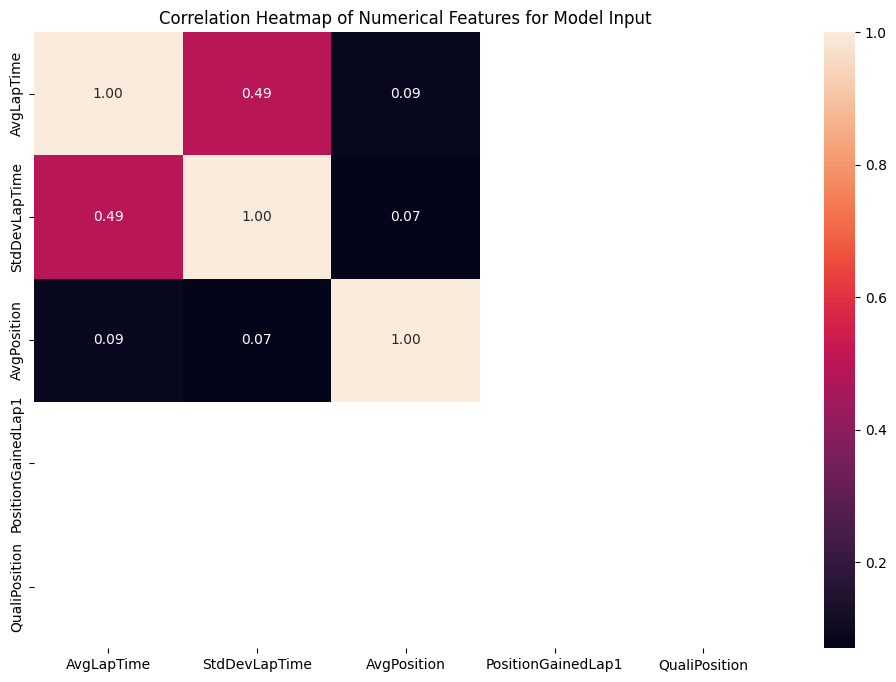

In [6]:
if 'features' in locals() and 'numerical_features' in locals():
    plt.figure(figsize=(12, 8))
    sns.heatmap(features[numerical_features].corr(), annot=True, fmt=".2f")
    plt.title('Correlation Heatmap of Numerical Features for Model Input')
    plt.show()
else:
    print("Features for visualization are not available.")

## 7. Train/Test Split and Model Preparation

In [7]:
if 'features' in locals() and 'target' in locals():
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

X_train shape: (159, 5)
X_test shape: (40, 5)
y_train shape: (159,)
y_test shape: (40,)


## 8. Model Selection and Training

In [8]:
if 'preprocessor' in locals():
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    }

    # Create and train pipelines
    pipelines = {}
    for name, model in models.items():
        pipelines[name] = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', model)])
        print(f"Training {name}...")
        pipelines[name].fit(X_train, y_train)

    print("\nModels trained successfully.")

/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training XGBoost...

Models trained successfully.

Models trained successfully.


/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:27:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 9. Model Evaluation and Metrics

--- Logistic Regression ---
Accuracy: 0.9750
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


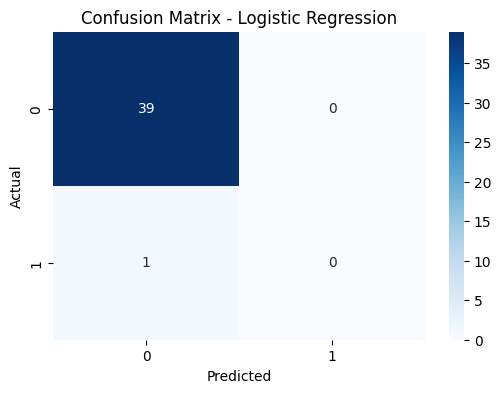

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


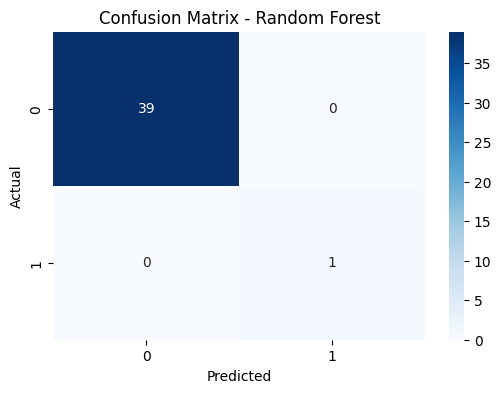

--- XGBoost ---
Accuracy: 0.9750
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


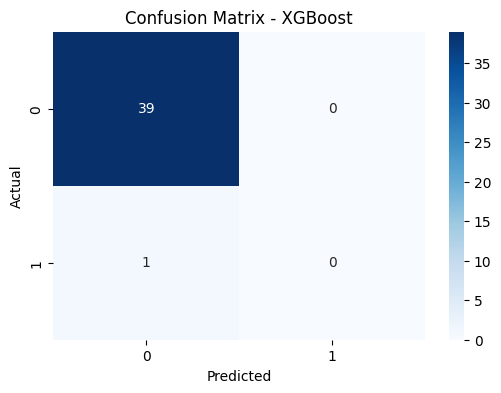


--- Model Comparison ---
                     Accuracy  Precision  Recall  F1-score
Logistic Regression     0.975        0.0     0.0       0.0
Random Forest           1.000        1.0     1.0       1.0
XGBoost                 0.975        0.0     0.0       0.0


In [9]:
if 'pipelines' in locals():
    results = {}
    for name, pipeline in pipelines.items():
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}
        print(f"--- {name} ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    results_df = pd.DataFrame(results).T
    print("\n--- Model Comparison ---")
    print(results_df)

## 10. Predicting Race Winners with the Model

In [10]:
if 'pipelines' in locals() and 'X_test' in locals():
    # Example: Predict on the test set
    best_model_name = results_df['Accuracy'].idxmax()
    best_model = pipelines[best_model_name]

    predictions = best_model.predict(X_test)
    prediction_proba = best_model.predict_proba(X_test)[:, 1]

    # Create a DataFrame with the original test data, including identifiers
    prediction_df = merged_df.loc[X_test.index].copy()
    prediction_df['Actual_Winner'] = y_test
    prediction_df['Predicted_Winner'] = predictions
    prediction_df['Prediction_Probability'] = prediction_proba

    print(f"--- Predictions using {best_model_name} ---")
    # Display results for one race to make it easier to see the winner prediction
    if not prediction_df.empty:
        example_race = prediction_df['RaceName'].unique()[0]
        print(f"\n--- Predictions for {example_race} ---")
        print(prediction_df[prediction_df['RaceName'] == example_race][['Driver', 'Actual_Winner', 'Predicted_Winner', 'Prediction_Probability']].sort_values(by='Prediction_Probability', ascending=False))
    else:
        print("No predictions to display.")

--- Predictions using Random Forest ---

--- Predictions for Spanish Grand Prix ---
    Driver  Actual_Winner  Predicted_Winner  Prediction_Probability
198    VER              0                 0                    0.02
192    NOR              0                 0                    0.02
195    RUS              0                 0                    0.00
184    BOR              0                 0                    0.00
188    HAM              0                 0                    0.00
183    BEA              0                 0                    0.00


/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [11]:
# --- Model Training and Evaluation with Cross-Validation ---
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Check if 'features' and 'target' are available
if 'features' in locals() and 'target' in locals() and not features.empty:
    # Create a pipeline with the preprocessor and the model
    # Use class_weight='balanced' to handle imbalanced classes
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])

    # Define the cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Define the scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Perform cross-validation
    cv_results = cross_validate(model_pipeline, features, target, cv=cv, scoring=scoring)

    # Print the cross-validation results
    print("Cross-Validation Results:")
    print(f"  Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
    print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
    print(f"  Recall: {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
    print(f"  F1-score: {cv_results['test_f1_score'].mean():.4f} (+/- {cv_results['test_f1_score'].std():.4f})")

    # Now, train the final model on the entire dataset for prediction
    print("\nTraining final model on the entire dataset...")
    model_pipeline.fit(features, target)
    print("Final model trained.")

    # Store the trained model and the original dataframe for predictions
    final_model = model_pipeline
    prediction_df = merged_df.copy()

else:
    print("Features or target not available. Skipping model training.")

# --- Make Predictions and Interpret Results ---

# Check if the final model and prediction data are available
if 'final_model' in locals() and 'prediction_df' in locals() and not prediction_df.empty:
    # Extract features for prediction
    prediction_features = prediction_df.drop(columns=['RaceName', 'Driver', 'IsWinner'])

    # Get predicted probabilities
    predicted_probabilities = final_model.predict_proba(prediction_features)[:, 1]
    prediction_df['PredictedWinnerProbability'] = predicted_probabilities

    # For each race, find the driver with the highest predicted probability
    predicted_winners = prediction_df.loc[prediction_df.groupby('RaceName')['PredictedWinnerProbability'].idxmax()]

    # Get the actual winners for comparison
    actual_winners = prediction_df[prediction_df['IsWinner'] == 1]

    # Create a summary dataframe
    results_summary = pd.merge(
        predicted_winners[['RaceName', 'Driver', 'PredictedWinnerProbability']],
        actual_winners[['RaceName', 'Driver']],
        on='RaceName',
        suffixes=['_Predicted', '_Actual']
    )
    results_summary.rename(columns={'Driver_Predicted': 'Predicted_Winner', 'Driver_Actual': 'Actual_Winner'}, inplace=True)

    # Calculate overall accuracy
    correct_predictions = (results_summary['Predicted_Winner'] == results_summary['Actual_Winner']).sum()
    total_predictions = len(results_summary)
    prediction_accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

    # Display the results
    print(f"Overall Prediction Accuracy: {prediction_accuracy:.2f}% ({correct_predictions}/{total_predictions})\n")
    print("Prediction Summary:")
    display(results_summary[['RaceName', 'Predicted_Winner', 'Actual_Winner', 'PredictedWinnerProbability']])

else:
    print("Final model or prediction data not available. Skipping predictions.")

/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/p

Cross-Validation Results:
  Accuracy: 0.9747 (+/- 0.0162)
  Precision: 0.2000 (+/- 0.4000)
  Recall: 0.2000 (+/- 0.4000)
  F1-score: 0.2000 (+/- 0.4000)

Training final model on the entire dataset...
Final model trained.
Overall Prediction Accuracy: 100.00% (5/5)

Prediction Summary:


/Users/hakonstorholt/code/formula_1_winner_predictor/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['PositionGainedLap1' 'QualiPosition']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


,RaceName,Predicted_Winner,Actual_Winner,PredictedWinnerProbability
0,Austrian Grand Prix,NOR,NOR,0.60
1,Bahrain Grand Prix,PIA,PIA,0.76
2,Emilia Romagna Grand Prix,VER,VER,0.81
3,Japanese Grand Prix,VER,VER,0.85
4,Saudi Arabian Grand Prix,PIA,PIA,0.61
